<a href="https://colab.research.google.com/github/rdemarqui/llm_complaint_management/blob/main/02.%20LLM_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM at Work: Decoding Customer Feedback

This study aims to explore the advanced LLM tool Mistral 7B to analyze a vast collection of complaints gathered from the website [reclameaqui.com.br](reclameaqui.com.br). Through this analysis, we intend to demonstrate the potential and effectiveness of LLMs in interpreting and handling large-scale user feedback.

For more information, please visit github page: https://github.com/rdemarqui/llm_complaint_management

## Complaint Dataset

### Load

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

sns.set_theme()

In [2]:
# Loading data
data_url = 'https://raw.githubusercontent.com/rdemarqui/llm_complaint_management/main/datasets/full_dataset_claro.xlsx'
data = pd.read_excel(data_url, usecols=['problem', 'description'])
print(data.shape)

(7000, 2)


### Clean

In [3]:
# Remove extra space and uncase all words
data['description'] = data['description'].astype(str)
data['description'] = data['description'].str.replace(r'\s{2,}', ' ', regex=True)
data['description'] = data['description'].str.lower()

In [4]:
# Modify mask made by reclame aqui
def remove_mask(text):
  return text.replace("[editado pelo reclame aqui]", "[mask]")

data['description'] = data['description'].apply(remove_mask)

In [5]:
# Remove description less than 3 characters
data = data[data['description'].str.len() > 3].copy()

### Stratify

As this work is intended for study purposes, we will only work with a fraction of the data. With the infrastructure provided by the Colab free tier, we noticed that on average, Mistral 7B analyzes about 2.000 complaints per hour. Therefore, we will use this number of cases in our analysis. To do this, we will perform a stratified sample.

We also will use validation data with 202 examples to test some prompt engineering.

In [6]:
# Get stratified data
df, data_val = train_test_split(data, train_size=2002, stratify=data['problem'], random_state=42)
df_val, _  = train_test_split(data_val, train_size=202, stratify=data_val['problem'], random_state=42)
df.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
print(f"Validation data: {df_val.shape} \nTest data: {df.shape}")

Validation data: (202, 2) 
Test data: (2002, 2)


In [7]:
# Export dataset to tag mannualy
df_val.to_excel('df_validation.xlsx', index=False)

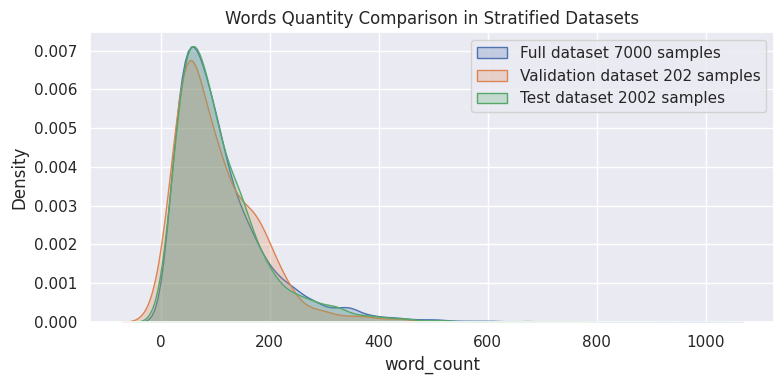

In [8]:
# Comparing word distributions
data['word_count'] = data['description'].str.split().str.len()
df['word_count'] = df['description'].str.split().str.len()
df_val['word_count'] = df_val['description'].str.split().str.len()

fig, ax = plt.subplots(figsize=(8, 4))
sns.kdeplot(data=data['word_count'], label='Full dataset 7000 samples', fill=True, ax=ax)
sns.kdeplot(data=df_val['word_count'], label='Validation dataset 202 samples', fill=True, ax=ax)
sns.kdeplot(data=df['word_count'], label='Test dataset 2002 samples', fill=True, ax=ax)
ax.legend()
plt.title('Words Quantity Comparison in Stratified Datasets')
plt.tight_layout()
plt.show()

### Analysis

In [9]:
df.head()

,problem,description,word_count
0,Problemas com o chip,boa noite!!!fiz uma portabilidade da vivo para...,203
1,Problemas com o chip,perdi meu celular e ao tentar solicitar um nov...,66
2,Corte indevido da linha,é a segunda reclamação que estou fazendo e a c...,32
3,Cancelamento,solicitei portabilidade da vivo para a claro p...,136
4,Problemas com o chip,"contratei este prezao celular, paguei 20,00 re...",13


In [10]:
# Show each problem category
df['problem'].value_counts()

Problemas com o chip                       143
Corte indevido da linha                    143
Cancelamento                               143
Problema com recarga                       143
Planos e tarifas                           143
Mudança de plano                           143
Promoções                                  143
Qualidade da internet                      143
Consumo de crédito                         143
Instabilidade do sinal                     143
Demora na execução                         143
Cobrança indevida                          143
Portabilidade                              143
Mau atendimento do prestador de serviço    143
Name: problem, dtype: int64

In [11]:
# Show words statistics
df['word_count'] = df['description'].str.split().str.len()
df['text_len'] = df['description'].str.len()
df['word_count'].describe()

count    2002.000000
mean      110.619381
std        86.131142
min         2.000000
25%        53.000000
50%        87.000000
75%       143.000000
max       747.000000
Name: word_count, dtype: float64

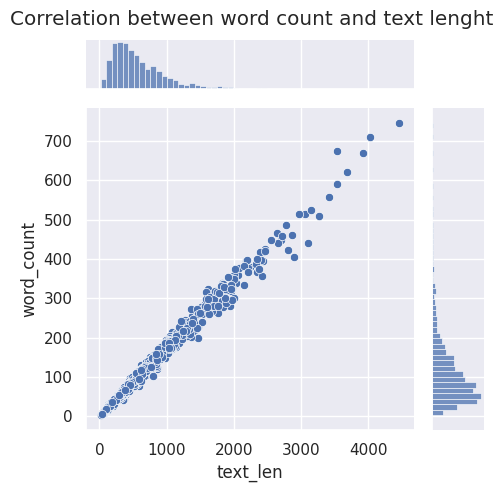

In [12]:
# Check correlation between word count and text lenght
chart_joint = sns.jointplot(data=df, x="text_len", y="word_count", height=5)
chart_joint.fig.suptitle("Correlation between word count and text lenght")
chart_joint.fig.tight_layout()
chart_joint.fig.subplots_adjust(top=0.92)

In [13]:
# Check word median per category
df.groupby('problem')['word_count'].median()

problem
Cancelamento                                95.0
Cobrança indevida                          113.0
Consumo de crédito                          83.0
Corte indevido da linha                    106.0
Demora na execução                          82.0
Instabilidade do sinal                      67.0
Mau atendimento do prestador de serviço     92.0
Mudança de plano                           100.0
Planos e tarifas                            98.0
Portabilidade                               99.0
Problema com recarga                        73.0
Problemas com o chip                        90.0
Promoções                                   63.0
Qualidade da internet                       74.0
Name: word_count, dtype: float64

## Text Classification

### Loading Model

There are several 7B models available as open source, such as Mistral, Falcon, Zephyr, and Openchat. In this study we will use Mistral, but other models can also be tested, just paying attention to adapting the instruction structure.

In [14]:
import time
from datetime import timedelta
from google.colab import files
from IPython.display import clear_output

In [15]:
# Latest HF transformers version for Mistral-like models
!pip install git+https://github.com/huggingface/transformers.git

# GPTQ Dependencies
!pip install optimum
!pip3 install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/  # Use cu117 if on CUDA 11.7

clear_output()

In [16]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

We will load the pre-trained Mistral 7B model, quantized by the user TheBloke and available at https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GPTQ.

For more information on quantization, there is an excellent article written by Maxime Labonne:
* https://towardsdatascience.com/introduction-to-weight-quantization-2494701b9c0c

In [17]:
# Load LLM and Tokenizer
model_id = "TheBloke/Mistral-7B-Instruct-v0.2-GPTQ"
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    trust_remote_code=False,
    revision="main"
)
clear_output()

In [294]:
# Create a pipeline
generator = pipeline(model=model,
                tokenizer=tokenizer,
                task='text-generation',
                max_new_tokens=60,
                temperature=0.1,
                do_sample=True,
                return_full_text = False
                )
clear_output()

### Prompt Engineering

**Note:** Depending on the amount of data, the classification process can take a few hours. Using the quantized model described above and utilizing the free tier infrastructure of Colab, I noticed that Mistral 7B takes about an hour to classify 2.000 cases.

Colab tends to disconnect due to inactivity. To prevent this, open your browser's inspector, go to the console tab, paste the code below, and press enter.

`function ClickConnect(){
    console.log("Working");
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)`

In [232]:
def llm_analysis(prompt, complain):
  response = generator(prompt.format(user_complain=complain))
  llm_classification = response[0]['generated_text'].replace('.', '').lower()

  return llm_classification

In [233]:
def iterate_over_interval(df, column, limit_char, start_row, end_row):
  start_time = time.time()

  for nloop, index in enumerate(range(start_row, end_row + 1)):
    complaint_content = str(df.loc[index, column]).lower()

    # Checkpoint
    if (nloop + 1) % 100 == 0:
      delta_time = str(timedelta(seconds=time.time() - start_time)).split('.')[0]
      print(f"{delta_time} Analysis number {nloop + 1}")

    # Limit text lengh
    if len(complaint_content) > limit_char: complaint_content = complaint_content[:limit_char]+'\n'

    #print(prompt.format(user_complain=complaint_content))  # check prompt

    # Text analysis
    analysis = llm_analysis(complaint_content)
    df.at[index, 'llm_class'] = analysis

  # Save final result
  delta_time = str(timedelta(seconds=time.time() - start_time)).split('.')[0]
  print(f"{nloop + 1} cases analyzed. Total execution time: {delta_time}")
  file_save = 'analise_reclamacao_' + str(start_row) + '_' + str(end_row) + '.xlsx'
  df.to_excel(file_save, index=False)

Prompt Guide:
* https://www.promptingguide.ai/models/mistral-7b
* https://huggingface.co/docs/transformers/main/tasks/prompting

In [234]:
# Define tags
tags = ['sinal/conexão de rede', 'cobrança indevida', 'consumo saldo/crédito',
        'plano/benefício', 'cancelamento linha/plano', 'recuperar número/linha',
        'chip/sim card', 'spam', 'portabilidade', 'recarga/pagamento', 'dificuldade de contato']

# Transform tag list in one string
tags_string = ", ".join(f"{tag}" for tag in tags)

tags_string

'sinal/conexão de rede, cobrança indevida, consumo saldo/crédito, plano/benefício, cancelamento linha/plano, recuperar número/linha, chip/sim card, spam, portabilidade, recarga/pagamento, dificuldade de contato'

In [281]:
# Multi-turn conversation

# Conversation 1 with 1 example
conv1_1e = """[INST]
Reclamação: A cobertura é ruim!
Tarefa: Classifique a reclamação.
Rótulos:[/INST] sinal/conexão de rede
"""

# Conversation 1 with 2 examples
conv1_2e = """[INST]
Reclamação: A cobertura é ruim! Meu chip não funciona!
Tarefa: Classifique a reclamação.
Rótulos:[/INST] sinal/conexão de rede, chip/sim card
"""

# Conversation 2 with 1 example
conv2_1e = """[INST]
Reclamação: Recebo muitas mensagens de propaganda.
Tarefa: Classifique a reclamação.
Rótulos:[/INST] spam
"""

# Conversation 2 with 2 examples
conv2_2e = """[INST]
Reclamação: Recebo muitas mensagens de propaganda. Meu saldo acaba rápido.
Tarefa: Classifique a reclamação.
Rótulos:[/INST] spam, consumo saldo/crédito
"""

In [282]:
complain_template = """
Reclamação: {user_complain}"""

task_template = """
Tarefa: Classifique a reclamação. Atenção use apenas as categorias abaixo, sem explicar.
{tags}
""".format(tags=tags_string)

In [283]:
# Prompt user complain without system prompt (role)
prompt_task_after = '[INST]' + complain_template + task_template + '\nRótulos:[/INST]'
prompt_task_before = '[INST]' + task_template + complain_template + '\nRótulos:[/INST]'

In [291]:
# Prompt zero shot
p_tsk_aft_zero = prompt_task_after
p_tsk_bfr_zero = prompt_task_before

# Prompt multiturn conversation, task after complain
p_tsk_aft_1c_1e = '<s>' + conv1_1e + '</s>\n' + prompt_task_after
p_tsk_aft_2c_1_2e = '<s>' + conv1_1e + conv2_2e + '</s>\n' + prompt_task_after
p_tsk_aft_1c_2e = '<s>' + conv1_2e + '</s>\n' + prompt_task_after
p_tsk_aft_2c_2e = '<s>' + conv1_2e + conv2_2e + '</s>\n' + prompt_task_after

# Prompt multiturn conversation, task before complain
p_tsk_bfr_1c_1e = '<s>' + conv1_1e + '</s>\n' + prompt_task_before
p_tsk_bfr_2c_1_2e = '<s>' + conv1_1e + conv2_2e + '</s>\n' + prompt_task_before
p_tsk_bfr_1c_2e = '<s>' + conv1_2e + '</s>\n' + prompt_task_before
p_tsk_bfr_2c_2e = '<s>' + conv1_2e + conv2_2e + '</s>\n' + prompt_task_before

prompt_dict = {'p_tsk_aft_zero': p_tsk_aft_zero, 'p_tsk_bfr_zero': p_tsk_bfr_zero,
               'p_tsk_aft_1c_1e': p_tsk_aft_1c_1e, 'p_tsk_aft_2c_1_2e': p_tsk_aft_2c_1_2e,
               'p_tsk_aft_1c_2e': p_tsk_aft_1c_2e, 'p_tsk_aft_2c_2e': p_tsk_aft_2c_2e,
               'p_tsk_bfr_1c_1e': p_tsk_bfr_1c_1e, 'p_tsk_bfr_2c_1_2e': p_tsk_bfr_2c_1_2e,
               'p_tsk_bfr_1c_2e': p_tsk_bfr_1c_2e, 'p_tsk_bfr_2c_2e': p_tsk_bfr_2c_2e}

In [ ]:
# Print each prompt
#for prompt in prompt_dict:
#  print('\n - ', prompt)
#  print(prompt_dict[prompt])

In [295]:
# Run the example few times to see model consistency
example ="""
como sempre, atendimento da claro vago e sem nenhuma solução. estou a uma semana sem serviço na minha linha, tentando falar na central e só fico presa na ura ou não consigo chegar a lugar algum. detalhe que tudo isso precisa ser feito de outro celular já que não tenho sinal!!!!!!!!!!!!!não é a primeira vez que fico sem sinal esse ano pelo chip virtual e que sou impactada em trabalho e já estou nisso a 1 semana. a resposta da central foi: vá até uma loja física. eu tenho um chip virtual, qual o sentido de ir a uma loja física olhar um chip virtual que o supervisor que consegui falar nem sabia do que se tratava???? fora que minha [ultima ida a loja fisica fui cobrada por um chip dependente indevido que colocaram na minha conta e que nunca recebi reembolso.segue protocolo:*******070quero saber qual o desconto que terei em fatura nesses dias sem serviço e não tenho disponibilidade para ir a loja física por isso adquiri um chip virtual pela facilidade (que não existe do lado de vocês) nesse processo.a qualidade do serviço é cada dia pior e eu ainda me pergunto pq sou cliente de vocës.
"""[:2000].lower()

for prompt in prompt_dict:
  print('\n - ', prompt)
  for i in list(range(1, 2)):
    analysis = llm_analysis(prompt_dict[prompt], example)
    print(analysis)


 -  p_tsk_aft_zero
 sinal/conexão de rede, cobrança indevida, dificuldade de contato

 -  p_tsk_bfr_zero
 sinal/conexão de rede, dificuldade de contato, cobrança indevida, chip/sim card

 -  p_tsk_aft_1c_1e
 sinal/conexão de rede, cobrança indevida, dificuldade de contato, chip/sim card

 -  p_tsk_aft_2c_1_2e
 sinal/conexão de rede, cobrança indevida, consumo saldo/crédito, plano/benefício, recuperar número/linha, chip/sim card, dificuldade de contato

 -  p_tsk_aft_1c_2e
 sinal/conexão de rede, cobrança indevida, chip/sim card, dificuldade de contato

 -  p_tsk_aft_2c_2e
 sinal/conexão de rede, cobrança indevida, consumo saldo/crédito, plano/benefício, chip/sim card, dificuldade de contato

 -  p_tsk_bfr_1c_1e
 sinal/conexão de rede, atendimento pessoal/assistência técnica, cobrança indevida

 -  p_tsk_bfr_2c_1_2e
 sinal/conexão de rede, atendimento pessoal, cobrança indevida, recuperar número/linha, chip/sim card, recarga/pagamento, dificuldade de contato

 -  p_tsk_bfr_1c_2e
 sinal

#### Multi-label Evaluation

In this section we will evaluate our prompt. To do that we labaled mannualy the **df_val** dataframe to use as comparision with model output.

There are a few metrics to evaluate multi-label classification, in this work we gonna use `classification_report`from `sklearn`, that is a well known package wich give us manny metrics to analyse. If you you want to know more about it, there's a good article made by Aniruddha Karajgi, on https://towardsdatascience.com/evaluating-multi-label-classifiers-a31be83da6ea.

In [11]:
from sklearn.metrics import classification_report

In [3]:
# Creates binary classification columns and sum total classifications
def binary_cols(dataframe, column):
  for tag in tags:
      dataframe[tag] = dataframe[column].apply(lambda x: 1 if tag in x else 0)

  dataframe[column + '_sum'] = dataframe[tags].sum(axis=1)

In [4]:
df_val_url = 'https://raw.githubusercontent.com/rdemarqui/llm_complaint_management/main/datasets/df_validation.xlsx'
df_val = pd.read_excel(df_val_url)

In [10]:
y_expected = df_val[tags]
y_pred = y_expected

In [ ]:
classification_report(y_expected, y_pred, output_dict=True, target_names=tags)

### Classification

**Note:** As can be seen in the analysis above, the complaints have a median of 86 words and a text length with a median of 500 characters. Few texts exceed 2000 characters, for this reason, we will limit the text size to be passed to the model to this value on `limit_char` parameter.

In [32]:
# Run text classification
iterate_over_interval(df=df, column="description",
                      limit_char=2000,
                      start_row=0, end_row=2001)

0:03:08 Analysis number 100
0:06:21 Analysis number 200
0:09:42 Analysis number 300
0:13:02 Analysis number 400
0:16:12 Analysis number 500
0:19:40 Analysis number 600
0:22:49 Analysis number 700
0:26:03 Analysis number 800
0:29:10 Analysis number 900
0:32:30 Analysis number 1000
0:35:39 Analysis number 1100
0:38:47 Analysis number 1200
0:42:03 Analysis number 1300
0:45:27 Analysis number 1400
0:48:41 Analysis number 1500
0:51:54 Analysis number 1600
0:55:23 Analysis number 1700
0:58:47 Analysis number 1800
1:02:04 Analysis number 1900
1:05:18 Analysis number 2000
2002 cases analyzed. Total execution time: 1:05:24


## Results

In [35]:
# Create binary classification columns
binary_cols(df, 'llm_class')

In [34]:
# Check the quantity os texts that weren't classified using at least one of tags
unknow_tags = (df['llm_class_sum'] == 0).sum()
print(f"There are {unknow_tags} texts classified without using at least one of correct tags (hallucination).")

There are 101 texts classified without using at least one of tags (hallucination).


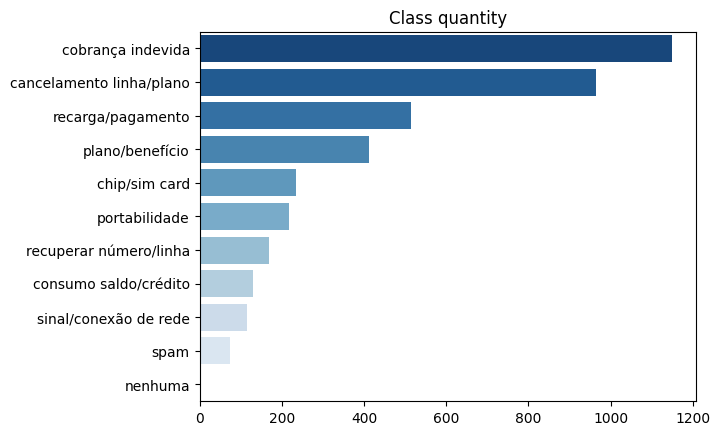

In [35]:
# Get class quantity
df_class = df[tags]
class_qty = df_class.sum()

chart_class = class_qty.sort_values(ascending=False)
sns.barplot(x=chart_class.values, y=chart_class.index, orient='h', palette='Blues_r')
plt.title('Class quantity');

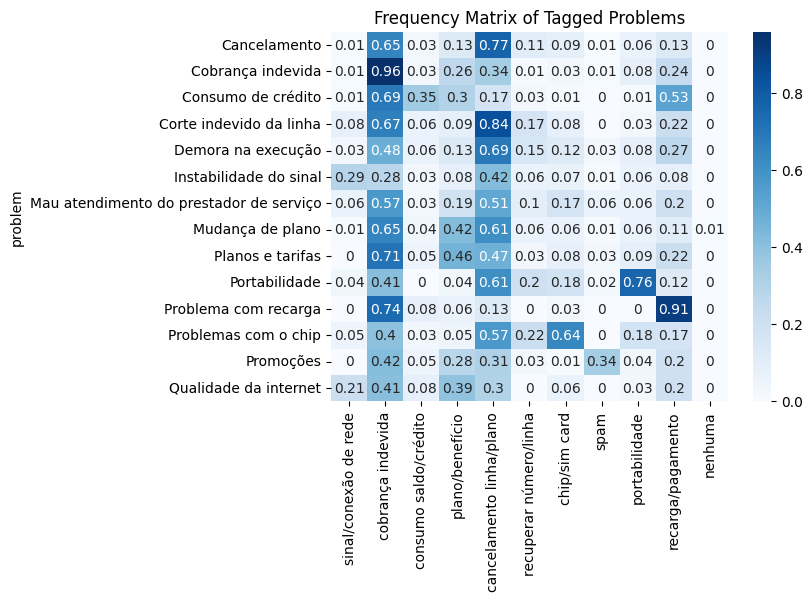

In [36]:
freq_matrix = round((df.groupby('problem')[tags].sum().T / df['problem'].value_counts().sort_index()), 2).T
sns.heatmap(freq_matrix, annot=True, cmap='Blues')
plt.title('Frequency Matrix of Tagged Problems');

In [37]:
df.to_excel('resultado.xlsx', index=False)

---